In [1]:
import pandas as pd
import numpy as np
import folium
from datetime import *
from PIL import Image, ImageDraw, ImageFont
from folium import plugins
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters
import time
import datetime
import os.path
import io

import os
os.environ["PATH"] += os.pathsep + "."

%matplotlib inline

In [2]:
# This is just a trial value
folium_map = folium.Map(location=[40.738, -73.98], # center point
                        zoom_start=13, # zoom value
                        tiles="CartoDB dark_matter")
# marker = folium.CircleMarker(location=[40.738, -73.98])
# marker.add_to(folium_map)

folium_map.save("my_map.html")

9.88% people start and end at the same station.
Few ID in the form of string and few in form of int

In [3]:
bike_data = pd.read_csv('202206-citbike-tripdata.csv')
bike_data

C:\Users\shahr\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


ride_id rideable_type           started_at  \
0        FD85DE523427365B  classic_bike  2022-06-08 18:55:00   
1        E1DF44B06B360036  classic_bike  2022-06-18 16:34:50   
2        72B6DBF42BC1F9E1  classic_bike  2022-06-11 17:57:00   
3        5FABA5CB97A6EA64  classic_bike  2022-06-23 17:32:04   
4        EBA54764AA1A3A41  classic_bike  2022-06-30 16:17:43   
...                   ...           ...                  ...   
3432878  52758C21D58728B4  classic_bike  2022-06-25 00:45:19   
3432879  2F2B099B77266BF2  classic_bike  2022-06-21 16:52:08   
3432880  AEE172A41A2FDA65  classic_bike  2022-06-29 17:58:20   
3432881  3E6A2E15FD49F94E  classic_bike  2022-06-16 19:31:34   
3432882  EA18E4BF86FD46F8  classic_bike  2022-06-16 12:15:02   

                    ended_at        start_station_name start_station_id  \
0        2022-06-08 18:58:13       E 149 St & Park Ave          7884.04   
1        2022-06-18 16:47:49    E 115 St & Madison Ave          7599.02   
2        2022-06-11 18:07:33    E 115 St & Madison Ave          7599.02   
3        2022-06-23 17:38:36    W Broadway & Spring St          5569.06   
4        2022-06-30 16:27:58           E 14 St & 1 Ave           5779.1   
...                      ...                       ...              ...   
3432878  2022-06-25 00:58:01   Norman St & Wyckoff Ave          4654.01   
3432879  2022-06-21 17:16:43    Railroad Ave & Kay Ave          4990.02   
3432880  2022-06-29 18:12:10  Bushwick Ave & Powers St          5250.05   
3432881  2022-06-16 19:42:42  Bushwick Ave & Powers St          5250.05   
3432882  2022-06-16 12:16:40        Broadway & W 51 St          6779.04   

                 end_station_name end_station_id  start_lat  start_lng  \
0           Morris Ave & E 153 St        7901.04  40.818154 -73.925294   
1        W 148 St & Amsterdam Ave        8033.09  40.798983 -73.944716   
2                 2 Ave & E 99 St        7386.10  40.798944 -73.944846   
3          N Moore St & Hudson St        5470.02  40.724947 -74.001659   
4                 5 Ave & E 29 St        6248.06  40.731393 -73.982867   
...                           ...            ...        ...        ...   
3432878       Grove St & Broadway        4526.01  40.695170 -73.903110   
3432879       Grove St & Broadway        4526.01  40.705148 -73.970781   
3432880        S 4 St & Wythe Ave        5204.05  40.712477 -73.941000   
3432881        S 4 St & Wythe Ave        5204.05  40.712477 -73.941000   
3432882           8 Ave & W 49 St        6747.07  40.762288 -73.983362   

           end_lat    end_lng member_casual  
0        40.820036 -73.921411        member  
1        40.827075 -73.945909        member  
2        40.786259 -73.945526        member  
3        40.719961 -74.008443        member  
4        40.745168 -73.986831        member  
...            ...        ...           ...  
3432878  40.690470 -73.923511        casual  
3432879  40.690470 -73.923511        member  
3432880  40.712859 -73.965903        member  
3432881  40.712859 -73.965903        member  
3432882  40.761712 -73.986551        member  

[3432883 rows x 13 columns]

In [4]:
# renaming the columns
bike_data.rename(columns={"started_at":"Start Time",
"ended_at":"Stop Time",
"start_station_name":"Start Station Name",
"start_station_id":"Start Station ID",
"end_station_name":"End Station Name",
"end_station_id":"End Station ID",
"start_lat":"Start Station Latitude",
"start_lng":"Start Station Longitude",
"end_lat":"End Station Latitude",
"end_lng":"End Station Longitude",}, inplace=True)

In [5]:
# drop all null values
bike_data.dropna(how='any', inplace=True)

In [6]:
# few values were str and few int, so changed all to str
bike_data['Start Station ID'] = bike_data['Start Station ID'].astype(str)
bike_data['End Station ID'] = bike_data['End Station ID'].astype(str)

In [7]:
# to DateTime data format
bike_data['Start Time'] = pd.to_datetime(bike_data['Start Time'])
bike_data['Stop Time'] = pd.to_datetime(bike_data['Stop Time'])
bike_data['Day'] = bike_data['Start Time'].dt.weekday
bike_data['Day'] # Monday = 0, Sunday = 6
bike_data["hour"] = bike_data["Start Time"].map(lambda x: x.hour)

In [8]:
# Various operations in date format
bike_data['Time'] = (bike_data['Stop Time'] - bike_data['Start Time'])
bike_data['Time'] =  bike_data['Time'].dt.total_seconds()
bike_data['Minutes'] = (bike_data['Time']/60).astype('int32')
bike_data['Hours'] = (bike_data['Time']/(60*60)).astype('int32')

In [9]:
bike_data

ride_id rideable_type          Start Time  \
0        FD85DE523427365B  classic_bike 2022-06-08 18:55:00   
1        E1DF44B06B360036  classic_bike 2022-06-18 16:34:50   
2        72B6DBF42BC1F9E1  classic_bike 2022-06-11 17:57:00   
3        5FABA5CB97A6EA64  classic_bike 2022-06-23 17:32:04   
4        EBA54764AA1A3A41  classic_bike 2022-06-30 16:17:43   
...                   ...           ...                 ...   
3432878  52758C21D58728B4  classic_bike 2022-06-25 00:45:19   
3432879  2F2B099B77266BF2  classic_bike 2022-06-21 16:52:08   
3432880  AEE172A41A2FDA65  classic_bike 2022-06-29 17:58:20   
3432881  3E6A2E15FD49F94E  classic_bike 2022-06-16 19:31:34   
3432882  EA18E4BF86FD46F8  classic_bike 2022-06-16 12:15:02   

                  Stop Time        Start Station Name Start Station ID  \
0       2022-06-08 18:58:13       E 149 St & Park Ave          7884.04   
1       2022-06-18 16:47:49    E 115 St & Madison Ave          7599.02   
2       2022-06-11 18:07:33    E 115 St & Madison Ave          7599.02   
3       2022-06-23 17:38:36    W Broadway & Spring St          5569.06   
4       2022-06-30 16:27:58           E 14 St & 1 Ave           5779.1   
...                     ...                       ...              ...   
3432878 2022-06-25 00:58:01   Norman St & Wyckoff Ave          4654.01   
3432879 2022-06-21 17:16:43    Railroad Ave & Kay Ave          4990.02   
3432880 2022-06-29 18:12:10  Bushwick Ave & Powers St          5250.05   
3432881 2022-06-16 19:42:42  Bushwick Ave & Powers St          5250.05   
3432882 2022-06-16 12:16:40        Broadway & W 51 St          6779.04   

                 End Station Name End Station ID  Start Station Latitude  \
0           Morris Ave & E 153 St        7901.04               40.818154   
1        W 148 St & Amsterdam Ave        8033.09               40.798983   
2                 2 Ave & E 99 St        7386.10               40.798944   
3          N Moore St & Hudson St        5470.02               40.724947   
4                 5 Ave & E 29 St        6248.06               40.731393   
...                           ...            ...                     ...   
3432878       Grove St & Broadway        4526.01               40.695170   
3432879       Grove St & Broadway        4526.01               40.705148   
3432880        S 4 St & Wythe Ave        5204.05               40.712477   
3432881        S 4 St & Wythe Ave        5204.05               40.712477   
3432882           8 Ave & W 49 St        6747.07               40.762288   

         Start Station Longitude  End Station Latitude  End Station Longitude  \
0                     -73.925294             40.820036             -73.921411   
1                     -73.944716             40.827075             -73.945909   
2                     -73.944846             40.786259             -73.945526   
3                     -74.001659             40.719961             -74.008443   
4                     -73.982867             40.745168             -73.986831   
...                          ...                   ...                    ...   
3432878               -73.903110             40.690470             -73.923511   
3432879               -73.970781             40.690470             -73.923511   
3432880               -73.941000             40.712859             -73.965903   
3432881               -73.941000             40.712859             -73.965903   
3432882               -73.983362             40.761712             -73.986551   

        member_casual  Day  hour    Time  Minutes  Hours  
0              member    2    18   193.0        3      0  
1              member    5    16   779.0       12      0  
2              member    5    17   633.0       10      0  
3              member    3    17   392.0        6      0  
4              member    3    16   615.0       10      0  
...               ...  ...   ...     ...      ...    ...  
3432878        casual    5     0   762.0       12      0  
3432879       

In [10]:
bike_data.groupby(bike_data['member_casual']).count()
bike_data.groupby(['rideable_type','member_casual']).count()

ride_id  Start Time  Stop Time  \
rideable_type member_casual                                   
classic_bike  casual          577270      577270     577270   
              member         1942529     1942529    1942529   
docked_bike   casual           35430       35430      35430   
electric_bike casual          217578      217578     217578   
              member          653720      653720     653720   

                             Start Station Name  Start Station ID  \
rideable_type member_casual                                         
classic_bike  casual                     577270            577270   
              member                    1942529           1942529   
docked_bike   casual                      35430             35430   
electric_bike casual                     217578            217578   
              member                     653720            653720   

                             End Station Name  End Station ID  \
rideable_type member_casual                                     
classic_bike  casual                   577270          577270   
              member                  1942529         1942529   
docked_bike   casual                    35430           35430   
electric_bike casual                   217578          217578   
              member                   653720          653720   

                             Start Station Latitude  Start Station Longitude  \
rideable_type member_casual                                                    
classic_bike  casual                         577270                   577270   
              member                        1942529                  1942529   
docked_bike   casual                          35430                    35430   
electric_bike casual                         217578                   217578   
              member                         653720                   653720   

                             End Station Latitude  End Station Longitude  \
rideable_type member_casual                                                
classic_bike  casual                       577270                 577270   
              member                      1942529                1942529   
docked_bike   casual                        35430                  35430   
electric_bike casual                       217578                 217578   
              member                       653720                 653720   

                                 Day     hour     Time  Minutes    Hours  
rideable_type member_casual                                               
classic_bike  casual          577270   577270   577270   577270   577270  
              member         1942529  1942529  1942529  1942529  1942529  
docked_bike   casual           35430    35430    35430    35430    35430  
electric_bike casual          217578   217578   217578   217578   217578  
              member          653720   653720   653720   653720   653720

In [11]:
(len(bike_data[bike_data["End Station ID"]==bike_data["Start Station ID"]]) / len(bike_data)) *100
bike_data[bike_data["End Station ID"]==bike_data["Start Station ID"]].groupby(['rideable_type','member_casual']).count()

ride_id  Start Time  Stop Time  \
rideable_type member_casual                                   
classic_bike  casual           42030       42030      42030   
              member           93870       93870      93870   
docked_bike   casual            3358        3358       3358   
electric_bike casual           14839       14839      14839   
              member           42983       42983      42983   

                             Start Station Name  Start Station ID  \
rideable_type member_casual                                         
classic_bike  casual                      42030             42030   
              member                      93870             93870   
docked_bike   casual                       3358              3358   
electric_bike casual                      14839             14839   
              member                      42983             42983   

                             End Station Name  End Station ID  \
rideable_type member_casual                                     
classic_bike  casual                    42030           42030   
              member                    93870           93870   
docked_bike   casual                     3358            3358   
electric_bike casual                    14839           14839   
              member                    42983           42983   

                             Start Station Latitude  Start Station Longitude  \
rideable_type member_casual                                                    
classic_bike  casual                          42030                    42030   
              member                          93870                    93870   
docked_bike   casual                           3358                     3358   
electric_bike casual                          14839                    14839   
              member                          42983                    42983   

                             End Station Latitude  End Station Longitude  \
rideable_type member_casual                                                
classic_bike  casual                        42030                  42030   
              member                        93870                  93870   
docked_bike   casual                         3358                   3358   
electric_bike casual                        14839                  14839   
              member                        42983                  42983   

                               Day   hour   Time  Minutes  Hours  
rideable_type member_casual                                       
classic_bike  casual         42030  42030  42030    42030  42030  
              member         93870  93870  93870    93870  93870  
docked_bike   casual          3358   3358   3358     3358   3358  
electric_bike casual         14839  14839  14839    14839  14839  
              member         42983  42983  42983    42983  42983

In [12]:
# select the first occurrence of each station id
locations = bike_data.groupby("Start Station ID").first()
# and select only the tree columns we are interested in
locations = locations.loc[:, ["Start Station Latitude",
                              "Start Station Longitude",
                              "Start Station Name"]]

In [13]:
locations

Start Station Latitude  Start Station Longitude  \
Start Station ID                                                    
2733.03                        40.633385               -74.016562   
2782.02                        40.635679               -74.020005   
2832.03                        40.637033               -74.022141   
2872.02                        40.637660               -74.017820   
2883.03                        40.638246               -74.024714   
...                                  ...                      ...   
8841.03                        40.882260               -73.887020   
Lab - NYC                      40.754166               -73.996534   
SYS016                         40.709667               -73.931505   
SYS032                         40.709581               -73.931422   
SYS038                         40.709306               -73.931175   

                               Start Station Name  
Start Station ID                                   
2733.03                           67 St & Erik Pl  
2782.02                             5 Ave & 66 St  
2832.03                     4 Ave & Shore Road Dr  
2872.02                             63 St & 5 Ave  
2883.03                        3 Ave & Wakeman Pl  
...                                           ...  
8841.03           W Mosholu Pkwy S & Sedgwick Ave  
Lab - NYC                               Lab - NYC  
SYS016                      Morgan Bike Mechanics  
SYS032                          Morgan WH station  
SYS038                       Morgan Loading Docks  

[1635 rows x 3 columns]

In [14]:
print(bike_data['Start Station ID'].nunique())
print(bike_data['End Station ID'].nunique())

1635
1646


In [15]:
selected_hour = 19

subset = bike_data[bike_data["hour"]==selected_hour]
departure_counts =  subset.groupby("Start Station ID").count()
# select one column
departure_counts = departure_counts.iloc[:,[0]]
# and rename that column
departure_counts.columns= ["Departure Count"]
departure_counts['Departure Count'].replace(np.nan,0, inplace=True)


In [16]:
departure_counts

Departure Count
Start Station ID                 
2733.03                        34
2782.02                        38
2832.03                        30
2872.02                         6
2883.03                        26
...                           ...
8799.01                        18
8811.01                         6
8841.03                        33
SYS032                         14
SYS038                          6

[1627 rows x 1 columns]

In [17]:
# subset = bike_data[bike_data["hour"]==selected_hour]
arrival_counts =  subset.groupby("End Station ID").count()
# select one column
arrival_counts = arrival_counts.iloc[:,[0]]
# and rename that column
arrival_counts.columns= ["Arrival Count"]
arrival_counts['Arrival Count'].replace(np.nan,0,inplace=True)

In [18]:
arrival_counts


Arrival Count
End Station ID               
2733.03                    40
2782.02                    42
2832.03                    26
2872.02                     9
2883.03                    25
...                       ...
JC093                       1
JC102                       1
JC104                       1
SYS032                      3
SYS035                      1

[1599 rows x 1 columns]

In [19]:
trip_counts = departure_counts.join(locations).join(arrival_counts)
trip_counts['Departure Count'].replace(np.nan,0,inplace=True)
trip_counts['Arrival Count'].replace(np.nan,0,inplace=True)
trip_counts

Departure Count  Start Station Latitude  \
Start Station ID                                            
2733.03                        34               40.633385   
2782.02                        38               40.635679   
2832.03                        30               40.637033   
2872.02                         6               40.637660   
2883.03                        26               40.638246   
...                           ...                     ...   
8799.01                        18               40.878120   
8811.01                         6               40.880279   
8841.03                        33               40.882260   
SYS032                         14               40.709581   
SYS038                          6               40.709306   

                  Start Station Longitude               Start Station Name  \
Start Station ID                                                             
2733.03                        -74.016562                  67 St & Erik Pl   
2782.02                        -74.020005                    5 Ave & 66 St   
2832.03                        -74.022141            4 Ave & Shore Road Dr   
2872.02                        -74.017820                    63 St & 5 Ave   
2883.03                        -74.024714               3 Ave & Wakeman Pl   
...                                   ...                              ...   
8799.01                        -73.891920           Goulden Ave & W 205 St   
8811.01                        -73.886160          Paul Ave & Mosholu Pkwy   
8841.03                        -73.887020  W Mosholu Pkwy S & Sedgwick Ave   
SYS032                         -73.931422                Morgan WH station   
SYS038                         -73.931175             Morgan Loading Docks   

                  Arrival Count  
Start Station ID                 
2733.03                    40.0  
2782.02                    42.0  
2832.03                    26.0  
2872.02                     9.0  
2883.03                    25.0  
...                         ...  
8799.01                    18.0  
8811.01                     9.0  
8841.03                    36.0  
SYS032                      3.0  
SYS038                      0.0  

[1627 rows x 5 columns]

In [20]:
def get_trip_counts_by_hour(selected_hour):
    locations = bike_data.groupby("Start Station ID").first()
    # and select only the tree columns we are interested in
    locations = locations.loc[:, ["Start Station Latitude",
                                "Start Station Longitude",
                                "Start Station Name"]]
    
    subset = bike_data[bike_data["hour"]==selected_hour]
    departure_counts =  subset.groupby("Start Station ID").count()
    # select one column
    departure_counts = departure_counts.iloc[:,[0]]
    # and rename that column
    departure_counts.columns= ["Departure Count"]
    departure_counts['Departure Count'].replace(np.nan,0, inplace=True)

    arrival_counts =  subset.groupby("End Station ID").count()
    # select one column
    arrival_counts = arrival_counts.iloc[:,[0]]
    # and rename that column
    arrival_counts.columns= ["Arrival Count"]
    arrival_counts['Arrival Count'].replace(np.nan,0,inplace=True)

    trip_counts = departure_counts.join(locations).join(arrival_counts)
    trip_counts['Departure Count'].replace(np.nan,0,inplace=True)
    trip_counts['Arrival Count'].replace(np.nan,0,inplace=True)
    return trip_counts

    

In [21]:
def plot_station_counts(trip_counts):
    folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="CartoDB dark_matter")
    
                        
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
        # generate the popup message that is shown on click.
        popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
        popup_text = popup_text.format(row["Start Station Name"],
                          row["Arrival Count"],
                          row["Departure Count"],
                          net_departures)
        
        # radius of circles
        radius = abs(net_departures/20)
        
        # choose the color of the marker
        if net_departures>0:
            # color="#FFCE00" # orange
            color="#007849" # green
            # color="#E37222" # tangerine
        else:
            # color="#0375B4" # blue
            color="#FFCE00" # yellow            
            # color="#0A8A9F" # teal
        
        # add marker to the map
        folium.CircleMarker(location=(row["Start Station Latitude"],
                                      row["Start Station Longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text,
                            fill=True).add_to(folium_map)
    return folium_map

In [22]:
# plot net departures at 9AM

trip_counts = get_trip_counts_by_hour(9)
plot_station_counts(trip_counts)

In [24]:
def get_kernel(kernel_size, blur=1/20, halo=.001):
    """
    Create an (n*2+1)x(n*2+1) numpy array.
    Output can be used as the kernel for convolution.
    """
    
    # generate x and y grids
    x, y = np.mgrid[0:kernel_size*2+1, 0:kernel_size*2+1]
    
    center = kernel_size + 1  # center pixel
    r = np.sqrt((x - center)**2 + (y - center)**2)  # distance from center
    
    # now compute the kernel. This function is a bit arbitrary. 
    # adjust this to get the effect you want.
    kernel = np.exp(-r/kernel_size/blur) + (1 - r/r[center,0]).clip(0)*halo
    return kernel

def add_lines(image_array, xys, width=1, weights=None):
    """
    Add a set of lines (xys) to an existing image_array
    width: width of lines
    weights: [], optional list of multipliers for lines. 
    """
    
    for i, xy in enumerate(xys):  # loop over lines
        # create a new gray scale image
        image = Image.new("L",(image_array.shape[1], image_array.shape[0]))
        
        # draw the line
        ImageDraw.Draw(image).line(xy, 200, width=width)
        
        #convert to array
        new_image_array = np.asarray(image, dtype=np.uint8).astype(float)
        
        # apply weights if provided
        if weights is not None:
            new_image_array *= weights[i]
            
        # add to existing array
        image_array += new_image_array

    # convolve image
    new_image_array = scipy.ndimage.filters.convolve(image_array, get_kernel(width*4)) 
    return new_image_array

In [25]:
def to_image(array, hue=.62):
    """converts an array of floats to an array of RGB values using a colormap"""
    
    # apply saturation function
    image_data = np.log(array + 1)
    
    # create colormap, change these values to adjust to look of your plot
    saturation_values = [[0, 0], [1, .68], [.78, .87], [0, 1]]
    colors = [hsv_to_rgb([hue, x, y]) for x, y in saturation_values]
    cmap = LinearSegmentedColormap.from_list("my_colormap", colors)
    
    # apply colormap
    out = cmap(image_data/image_data.max())
    
    # convert to 8-bit unsigned integer
    out = (out*255).astype(np.uint8)
    return out

In [26]:
min_lat = bike_data["Start Station Latitude"].min()
max_lat = bike_data["Start Station Latitude"].max()
max_lon = bike_data["Start Station Longitude"].max()
min_lon = bike_data["Start Station Longitude"].min()

def latlon_to_pixel(lat, lon, image_shape):
    # longitude to pixel conversion (fit data to image)
    delta_x = image_shape[1]/(max_lon-min_lon)
    
    # latitude to pixel conversion (maintain aspect ratio)
    delta_y = delta_x/np.cos(lat/360*np.pi*2)
    pixel_y = (max_lat-lat)*delta_y
    pixel_x = (lon-min_lon)*delta_x
    return (pixel_y,pixel_x)


def row_to_pixel(row,image_shape):
    """
    convert a row (1 trip) to pixel coordinates
    of start and end point
    """
    start_y, start_x = latlon_to_pixel(row["Start Station Latitude"], 
                                       row["Start Station Longitude"], image_shape)
    end_y, end_x = latlon_to_pixel(row["End Station Latitude"], 
                                   row["End Station Longitude"], image_shape)
    xy = (start_x, start_y, end_x, end_y)
    return xy

In [27]:
## Part 3

In [28]:
def interpolate(df1, df2, x):
    """return a weighted average of two dataframes"""
    df = df1 * (1 - x) + df2 * x
    return df.replace(np.nan, 0)


def get_trip_counts_by_minute(float_hour):
    """get an interpolated dataframe for any time, based
    on hourly data"""
    
    columns = ["Start Station Latitude",
               "Start Station Longitude",
               "Departure Count",
               "Arrival Count"]
    df1 = get_trip_counts_by_hour(int(float_hour))
    df2 = get_trip_counts_by_hour(int(float_hour) + 1)
    
    df = interpolate(df1.loc[:,columns], 
                     df2.loc[:,columns], 
                     float_hour % 1)
    
    df["Start Station Name"] = df1["Start Station Name"]
    return df

In [29]:
plot_station_counts(get_trip_counts_by_minute(9.5))
#Few stations seems to be in the same place, they have different ID's but same name
#1615 unique station ID's
#1537 unique station name

In [30]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = get_trip_counts_by_minute(hour_of_day)
    my_frame = plot_station_counts(data)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = int((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    font = ImageFont.truetype("Roboto-Light.ttf", 30)
    
    # draw time of day text
    draw.text((20,image.height - 50), 
              "time: {:0>2}:{:0>2}h".format(hour, minutes),
              fill=(255, 255, 255), 
              font=font)
    
    # draw title
    draw.text((image.width - 400,20), 
              "Net Arrivals vs Time of Day",
              fill=(255, 255, 255), 
              font=font)
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image

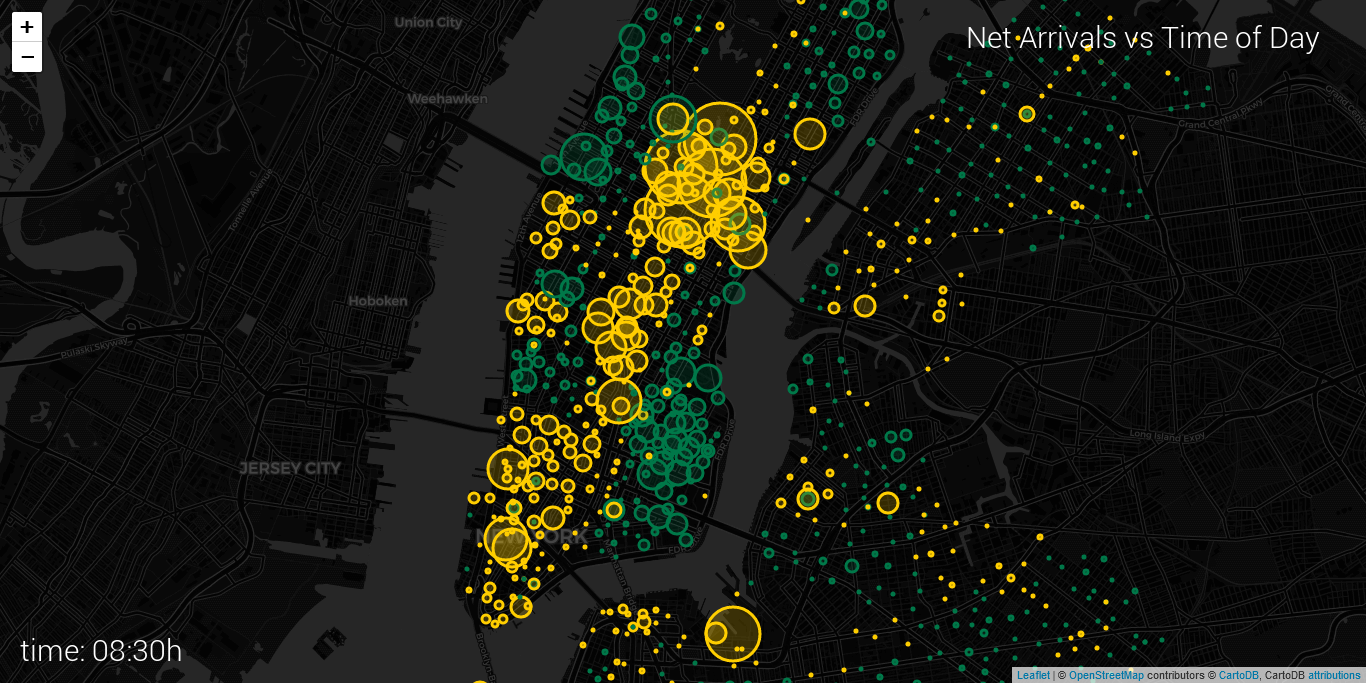

In [31]:
dir_name = 'frames'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
go_arrivals_frame(1, 8.5, dir_name)

In [32]:
# Frames from 6AM to 11PM at every 12 minute
arrival_times = np.arange(6, 23, .2)
for i, hour in enumerate(arrival_times):
    go_arrivals_frame(i, hour, "frames")

In [ ]:
trip_counts[['Start Station Latitude','Start Station Longitude']]

Start Station Latitude  Start Station Longitude
Start Station ID                                                 
2733.03                        40.633385               -74.016562
2782.02                        40.635679               -74.020005
2832.03                        40.637033               -74.022141
2872.02                        40.637660               -74.017820
2883.03                        40.638246               -74.024714
...                                  ...                      ...
8795.01                        40.879350               -73.885340
8795.03                        40.877964               -73.884755
8799.01                        40.878120               -73.891920
8811.01                        40.880279               -73.886160
8841.03                        40.882260               -73.887020

[1615 rows x 2 columns]

In [ ]:
trip_counts.index.nunique()

1615

In [ ]:
# Frame regenerate for wrong frames
start_time = pd.to_datetime('2022-10-05 06:00:00')
frame_times = [(i, start_time + datetime.timedelta(seconds=30*i)) for i in range(int(120))]

frames_to_redo = [29,40]
for frame in frames_to_redo:
    go_arrivals_frame(frame_times[frame][0],frame_times[frame][1].hour,'frames')

In [ ]:
#Converting frames to video
import cv2
import os

image_folder = 'frames'
video_name = 'video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()